### Covert Timing Channel Detection - Jupyter Notebook Implementation

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import moments
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os

### Configuration

In [50]:
IAT_CSV_FILE = 'iat_data.csv'
FEATURE_CSV_FILE = 'image_features.csv'
IMAGE_OUTPUT_DIR = 'iat_images'
MODEL_DIR = 'models'
os.makedirs(IMAGE_OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

### Image Creation and Feature Extraction

In [51]:
def create_colored_image(iats, img_size=16, save_path=None):
    """
    Create colored image from IATs
    Args:
        iats: List of 256 inter-arrival times
        img_size: Size of output image (16x16)
        save_path: If provided, saves image to this path
    Returns:
        Normalized image matrix (16x16)
    """
    # Normalize to 0-255 range
    iats = np.array(iats)
    if np.max(iats) - np.min(iats) > 0:
        norm_iats = 255 * (iats - np.min(iats)) / (np.max(iats) - np.min(iats))
    else:
        norm_iats = np.zeros_like(iats)
    
    # Reshape to 16x16 matrix
    img_matrix = norm_iats.reshape((img_size, img_size))
    
    # Save visualization if requested
    if save_path:
        plt.figure(figsize=(2, 2))
        plt.imshow(img_matrix, cmap='viridis')
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    
    return img_matrix

In [52]:
def extract_image_features(img_matrix):
    """
    Extract 8 features from image matrix
    Args:
        img_matrix: 16x16 normalized image matrix
    Returns:
        Dictionary of 8 features
    """
    # Ensure we're working with grayscale (2D matrix)
    if len(img_matrix.shape) == 3:
        img_matrix = np.mean(img_matrix, axis=2)
    
    features = {}
    
    # 1. Mean gray value
    features['mean_gray'] = np.mean(img_matrix)
    
    # 2. Standard deviation
    features['std_dev'] = np.std(img_matrix)
    
    # 3. Mode (most frequent value)
    hist, bin_edges = np.histogram(img_matrix, bins=256)
    features['mode'] = bin_edges[np.argmax(hist)]
    
    # 4. Center of mass (spatial moments)
    m = moments(img_matrix, order=1)
    features['center_x'], features['center_y'] = m[1, 0]/m[0, 0], m[0, 1]/m[0, 0]
    
    # 5. Integrated density
    features['integrated_density'] = np.sum(img_matrix)
    
    # 6. Median
    features['median'] = np.median(img_matrix)
    
    # 7. Skewness
    std = np.std(img_matrix)
    if std > 0:
        features['skewness'] = np.mean((img_matrix - features['mean_gray'])**3) / (std**3)
    else:
        features['skewness'] = 0
    
    # 8. Kurtosis
    if std > 0:
        features['kurtosis'] = np.mean((img_matrix - features['mean_gray'])**4) / (std**4)
    else:
        features['kurtosis'] = 0
    
    return features

### Processing Data

In [53]:
def process_iat_data():
    """Main processing function"""
    # Load IAT data
    df = pd.read_csv(IAT_CSV_FILE)
    print(f"Loaded {len(df)} IAT samples")
    
    # Process each sample
    features = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing IATs"):
        # Create image
        img_matrix = create_colored_image(
            row[1:257].values,  # IAT values (columns 1-256)
            save_path=os.path.join(IMAGE_OUTPUT_DIR, f'iat_image_{idx}.png')
        )
        
        # Extract features
        feat = extract_image_features(img_matrix)
        feat['label'] = row['label']  # Add label
        features.append(feat)
    
    # Convert to DataFrame and save
    feature_df = pd.DataFrame(features)
    feature_df.to_csv(FEATURE_CSV_FILE, index=False)
    print(f"Saved features to {FEATURE_CSV_FILE}")
    
    return feature_df

# Run the processing
feature_df = process_iat_data()

Loaded 404 IAT samples


Processing IATs:   0%|          | 0/404 [00:00<?, ?it/s]

Saved features to image_features.csv


### EDA

   mean_gray    std_dev  mode  center_x   center_y  integrated_density  \
0  18.205589  65.107098   0.0  6.162461   8.667224         4660.630871   
1  12.155254  53.730425   0.0  6.302881   7.379849         3111.745138   
2   4.012166  28.512360   0.0  7.971132   4.863694         1027.114607   
3   5.615843  33.816318   0.0  7.414424   6.400536         1437.655897   
4   4.073603  28.978122   0.0  8.475138  10.313370         1042.842368   

     median  skewness   kurtosis  label  
0  0.006718  3.344044  12.213361    1.0  
1  0.005970  4.277583  19.324104    1.0  
2  0.001628  8.155566  70.560486    1.0  
3  0.001475  6.601602  47.024633    1.0  
4  0.001060  7.906396  66.733730    1.0  
label
0.0    390
1.0     14
Name: count, dtype: int64


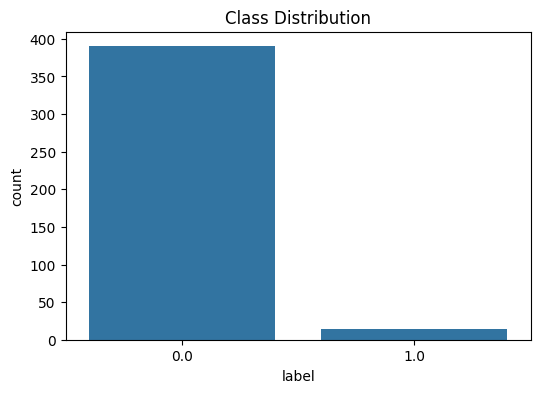

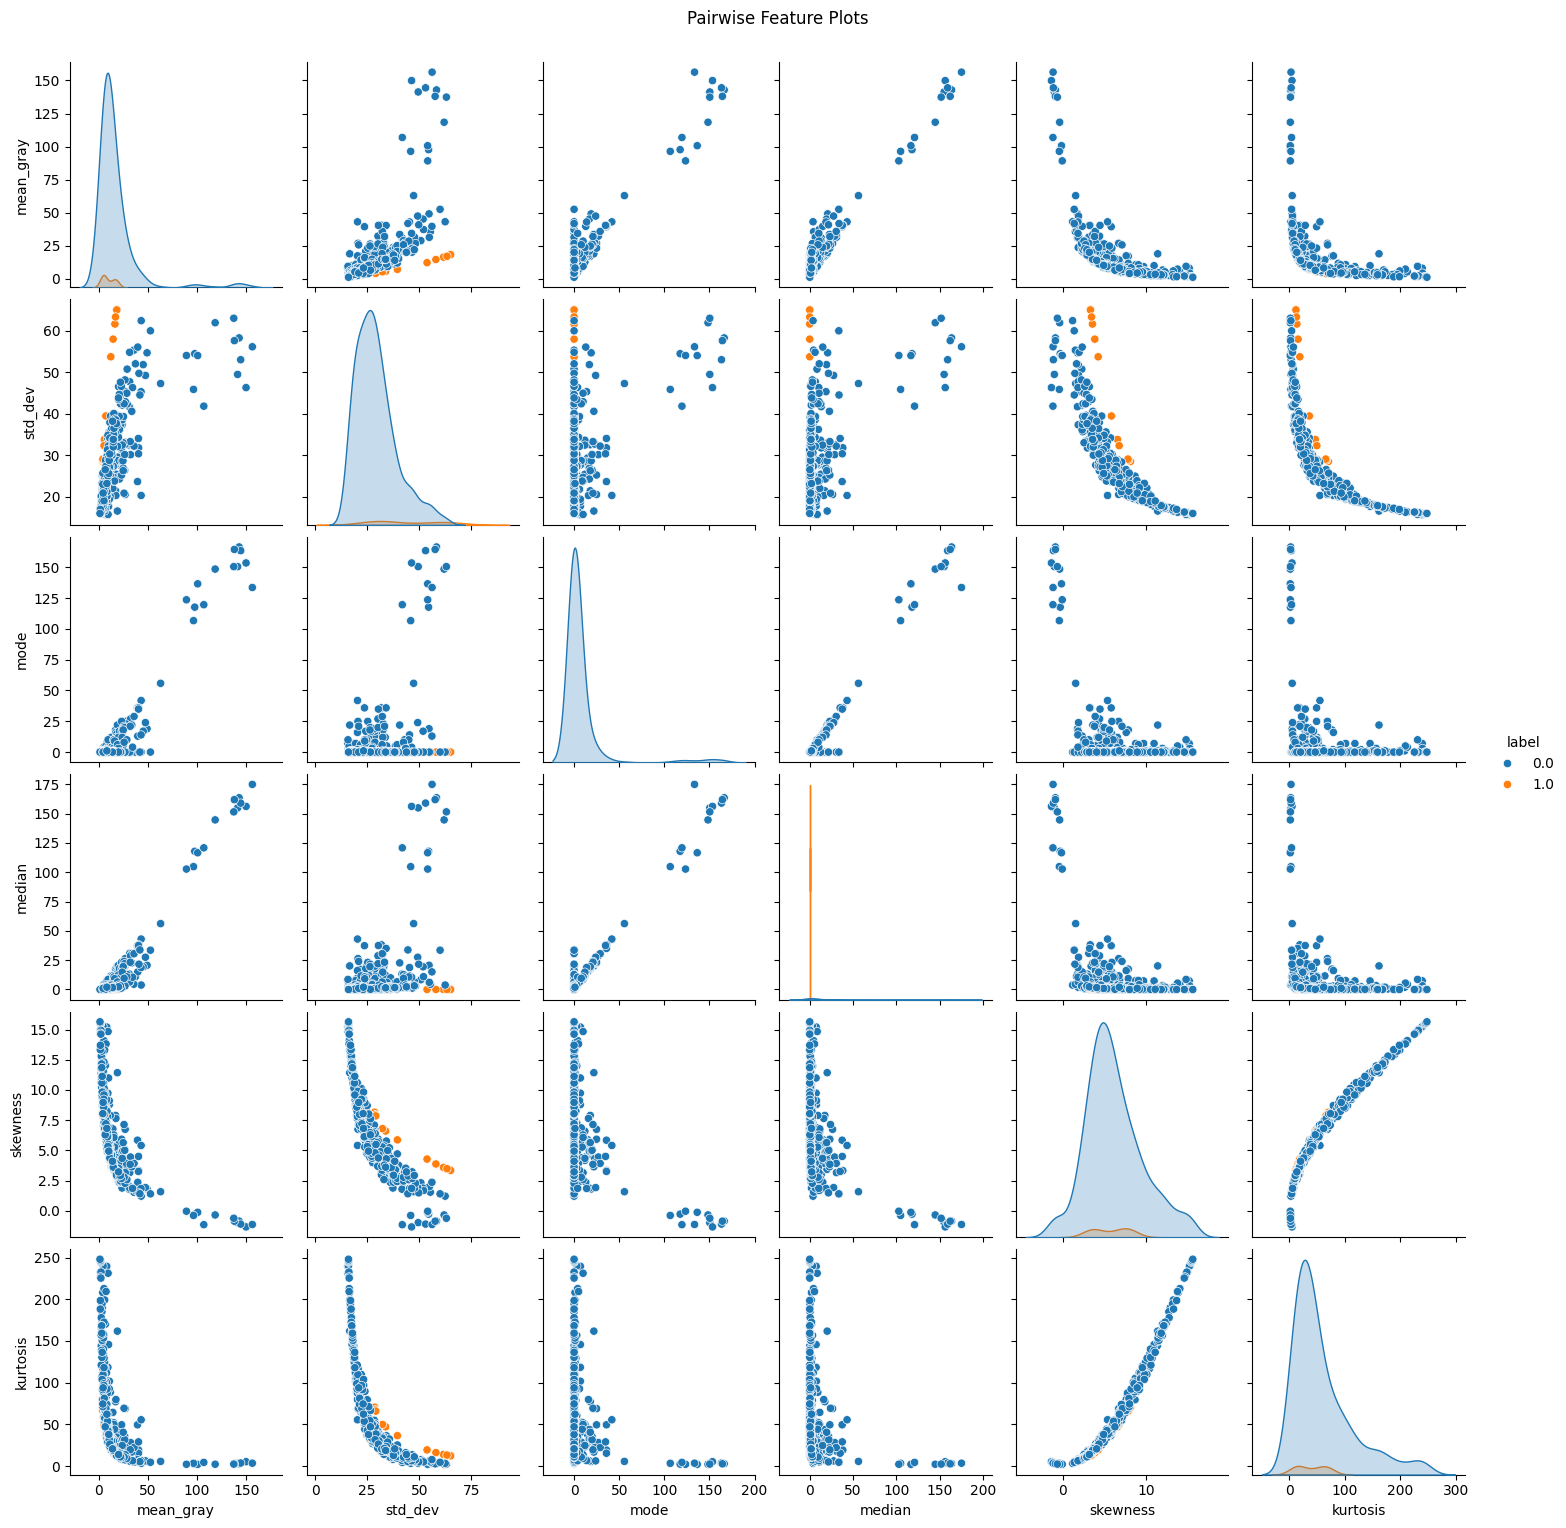

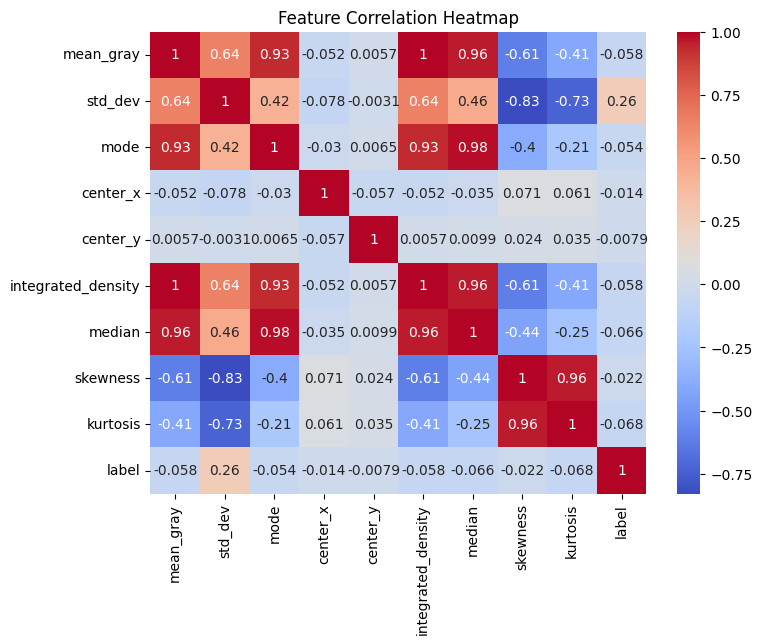

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Load the dataset
df = feature_df
print(df.head())
print(df['label'].value_counts())

# Convert labels to numeric for ML algorithms
df['label_name'] = df['label'].map({0: 'normal', 1: 'ctc'})

# Plot class distribution
plt.figure(figsize=(6, 4))

sns.countplot(data=df, x='label')
plt.title("Class Distribution")
plt.show()

# Plot pairwise feature relationships
sns.pairplot(df, hue='label', vars=['mean_gray', 'std_dev', 'mode', 'median','skewness','kurtosis'])
plt.suptitle("Pairwise Feature Plots", y=1.02)
plt.show()

# Feature correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns='label_name').corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

### Model Training

In [62]:
def train_models():
    """Train and evaluate models"""
    # Load features
    feature_df = pd.read_csv(FEATURE_CSV_FILE)
    X = feature_df.drop('label', axis=1).values
    y = feature_df['label'].values
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y)
    
    ### Decision Tree
    print("\n=== Training Decision Tree ===")
    dt = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=10,
        random_state=42
    )
    dt.fit(X_train, y_train)
    
    # Evaluate
    y_pred = dt.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))
    
    ### ANN
    print("\n=== Training ANN ===")
    ann = MLPClassifier(
        hidden_layer_sizes=(50, 30, 10),
        activation='logistic',
        solver='sgd',
        max_iter=500,
        random_state=42
    )
    ann.fit(X_train, y_train)
    
    # Evaluate
    y_pred = ann.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

    ### SVM
    print("\n=== Training SVM ===")
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    svm.fit(X_train, y_train)

    # Evaluate
    y_pred = svm.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))
    
    return dt, ann, svm

# Train models
dt_model, ann_model, svm_model = train_models()


=== Training Decision Tree ===
Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        98
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101


=== Training ANN ===
Accuracy: 0.9702970297029703
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        98
         1.0       0.00      0.00      0.00         3

    accuracy                           0.97       101
   macro avg       0.49      0.50      0.49       101
weighted avg       0.94      0.97      0.96       101


=== Training SVM ===
Accuracy: 0.9702970297029703
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        98
         1.0       0.00      0.00      0.00         3

    accuracy                      

### Saving ML Models

In [63]:
# Decision Tree
dt_path = os.path.join(MODEL_DIR, 'dt_model.pkl')
joblib.dump(dt_model, dt_path)
print(f"Saved Decision Tree to {dt_path}")

# ANN
ann_path = os.path.join(MODEL_DIR, 'ann_model.pkl')
joblib.dump(ann_model, ann_path)
print(f"Saved ANN to {ann_path}")

# SVM
svm_path = os.path.join(MODEL_DIR, 'svm_model.pkl')
joblib.dump(svm_model, svm_path)
print(f"Saved Support Vector Machine to {svm_path}")

Saved Decision Tree to models\dt_model.pkl
Saved ANN to models\ann_model.pkl
Saved Support Vector Machine to models\svm_model.pkl


### Visualization

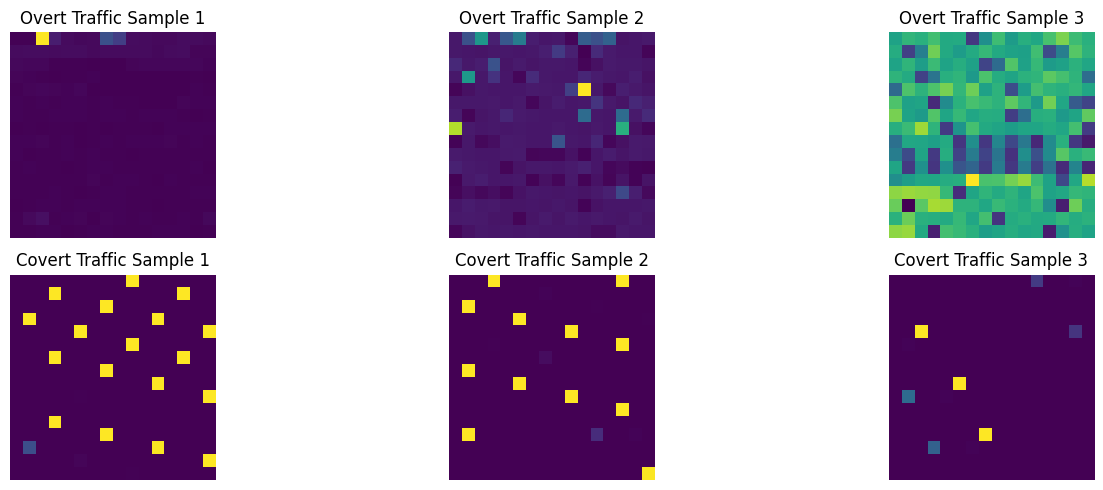

In [64]:
def show_example_images(n=3):
    """Display example images from the dataset"""
    df = pd.read_csv(IAT_CSV_FILE)
    
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Get overt and covert examples
        overt_sample = df[df['label'] == 0].iloc[i, 1:257].values
        covert_sample = df[df['label'] == 1].iloc[i, 1:257].values
        
        # Create images
        overt_img = create_colored_image(overt_sample)
        covert_img = create_colored_image(covert_sample)
        
        # Plot
        plt.subplot(2, n, i+1)
        plt.imshow(overt_img, cmap='viridis')
        plt.title(f"Overt Traffic Sample {i+1}")
        plt.axis('off')
        
        plt.subplot(2, n, n+i+1)
        plt.imshow(covert_img, cmap='viridis')
        plt.title(f"Covert Traffic Sample {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display image visualization
show_example_images()